In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import random


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rlcmab_sampler import sampler


In [3]:
roll_number = 4
reward_sampler = sampler(roll_number)

In [4]:
T = 10000

In [5]:
contexts = ['user1', 'user2', 'user3']
categories = ["ENTERTAINMENT", "EDUCATION", "TECH", "CRIME"]


In [6]:
def arm_index(context_id, category_id):
    # context_id = 0,1,2
    # category_id = 0,1,2,3
    return context_id * 4 + category_id



In [7]:
def select_best_category(Q):
    # greedy (choose argmax Q)
    return int(np.argmax(Q))

In [8]:
epsilons = [0.01, 0.05, 0.1]
results_egreedy = {eps: {} for eps in epsilons}

In [9]:
for eps in epsilons:
    for context_idx, context_name in enumerate(contexts):
        Q = np.zeros(len(categories), dtype = float) # Q-value for categories of news
        N = np.zeros(len(categories), dtype = int) # count for each categpry, i.e., how many times reward for each category is called/estimated.
        rewards = np.zeros(T, dtype=float) # per step reward

        for t in range(T):
            if np.random.rand() < eps:
                category_idx = np.random.randint(len(categories)) # explore from categories
            else:
                max_q = np.max(Q) # exploit by taking max 
                # but there can be multiple max_q. if we always pics the first max then we will be bias toward one category.
                candidates = [i for i, x in enumerate(Q) if x == max_q]
                category_idx = np.random.choice(candidates)
            
            # sample reward for category/arm
            j = arm_index(context_idx, category_idx)
            r = reward_sampler.sample(j)

            N[category_idx] += 1
            Q[category_idx] += (r - Q[category_idx]) / N[category_idx]
            rewards[t] = r
        
        avg_rewards = np.cumsum(rewards) / (np.arange(T) + 1)

        results_egreedy[eps][context_name] = {
            "Q": Q.copy(),
            "N": N.copy(),
            "rewards": rewards,
            "avg_rewards": avg_rewards
        }

                

In [10]:
for eps in epsilons:
    print(f"\nEpsilon={eps}")
    for context_name in contexts:
        Q = results_egreedy[eps][context_name]["Q"]
        print(f"  {context_name} Q-values: " + ", ".join([f"{cat}:{q:.4f}" for cat,q in zip(categories, Q)]))
        


Epsilon=0.01
  user1 Q-values: ENTERTAINMENT:-7.1559, EDUCATION:0.8655, TECH:-0.6990, CRIME:-4.2749
  user2 Q-values: ENTERTAINMENT:6.3056, EDUCATION:3.9552, TECH:2.5453, CRIME:8.1195
  user3 Q-values: ENTERTAINMENT:-2.0684, EDUCATION:-8.4841, TECH:5.7057, CRIME:-0.5627

Epsilon=0.05
  user1 Q-values: ENTERTAINMENT:-7.2156, EDUCATION:0.8775, TECH:-0.6274, CRIME:-4.1376
  user2 Q-values: ENTERTAINMENT:5.9817, EDUCATION:3.7223, TECH:2.6895, CRIME:8.1235
  user3 Q-values: ENTERTAINMENT:-1.8099, EDUCATION:-8.8396, TECH:5.7137, CRIME:-0.4490

Epsilon=0.1
  user1 Q-values: ENTERTAINMENT:-7.2026, EDUCATION:0.8660, TECH:-0.6110, CRIME:-4.0910
  user2 Q-values: ENTERTAINMENT:6.0836, EDUCATION:3.7782, TECH:2.7208, CRIME:8.1109
  user3 Q-values: ENTERTAINMENT:-2.0384, EDUCATION:-8.9026, TECH:5.6980, CRIME:-0.4252


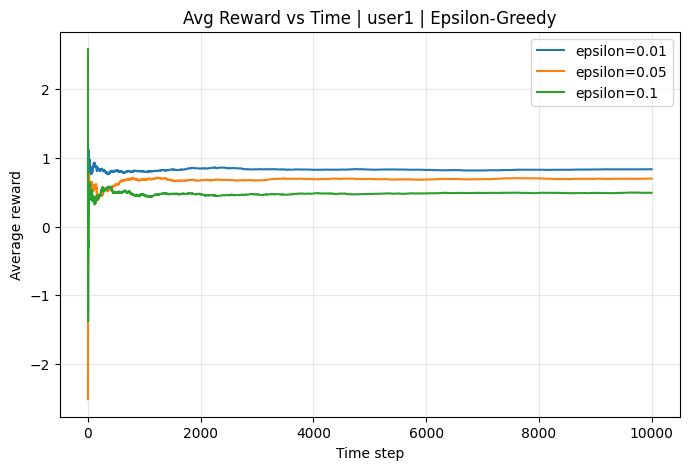

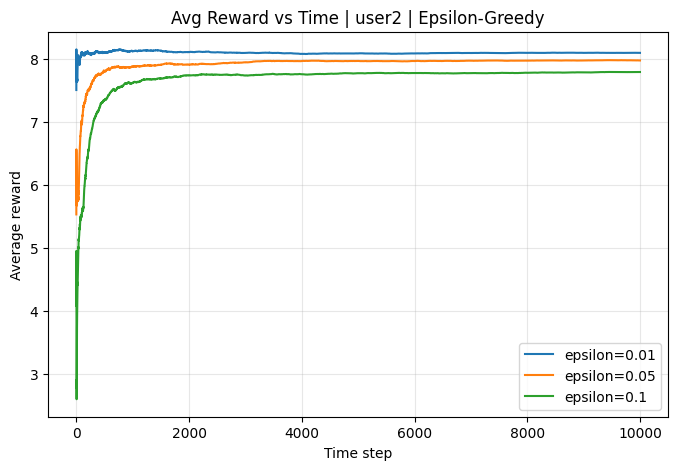

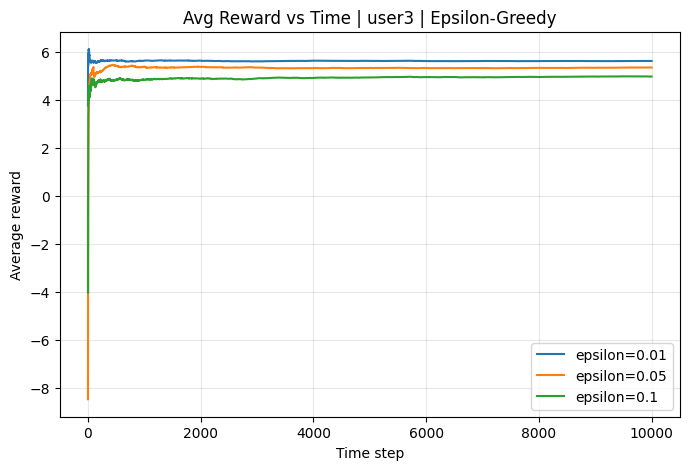

In [11]:
for context_name in contexts:
    plt.figure(figsize=(8,5))
    for eps in epsilons:
        avg = results_egreedy[eps][context_name]['avg_rewards']
        plt.plot(avg, label=f"epsilon={eps}")
    plt.title(f"Avg Reward vs Time | {context_name} | Epsilon-Greedy")
    plt.xlabel("Time step")
    plt.ylabel("Average reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [12]:
Cs = [0.5, 1.0, 2.0]
results_ucb = {C:{} for C in Cs}

In [13]:
for C in Cs:
    for context_idx, context_name in enumerate(contexts):
        Q = np.zeros(len(categories), dtype = float)
        N = np.zeros(len(categories), dtype = int)
        rewards = np.zeros(T, dtype = float)

        for t in range(T):
            if (N == 0).any():
                category_idx = np.where(N==0)[0][0]
            else:
                ucb = Q + C * np.sqrt(np.log(t+1)/N)
                category_idx = int(np.argmax(ucb))
                
            j = arm_index(context_idx, category_idx)
            r = reward_sampler.sample(j)

            N[category_idx] += 1
            Q[category_idx] += (r - Q[category_idx])/N[category_idx]
            rewards[t] = r
            
        avg_rewards = np.cumsum(rewards)/(np.arange(T) + 1)

        results_ucb[C][context_name] = {
            'Q' : Q.copy(),
            'N' : N.copy(),
            'rewards' : rewards,
            "avg_rewards" : avg_rewards
        }

In [14]:
for C in Cs:
    print(f"C = {C}")
    for context_name in contexts:
        Q = results_ucb[C][context_name]['Q']
        print(f"  {context_name} Q-values: " + ", ".join([f"{cat}:{q:.4f}" for cat,q in zip(categories, Q)]))
        

C = 0.5
  user1 Q-values: ENTERTAINMENT:-6.1271, EDUCATION:0.8587, TECH:-0.5274, CRIME:-3.7672
  user2 Q-values: ENTERTAINMENT:6.5552, EDUCATION:3.9509, TECH:3.5935, CRIME:8.1067
  user3 Q-values: ENTERTAINMENT:-1.1412, EDUCATION:-9.3634, TECH:5.7178, CRIME:1.1156
C = 1.0
  user1 Q-values: ENTERTAINMENT:-5.6558, EDUCATION:0.8503, TECH:-0.3982, CRIME:-3.5973
  user2 Q-values: ENTERTAINMENT:6.5993, EDUCATION:4.9816, TECH:3.0274, CRIME:8.1224
  user3 Q-values: ENTERTAINMENT:-1.6968, EDUCATION:-6.9089, TECH:5.7035, CRIME:0.2807
C = 2.0
  user1 Q-values: ENTERTAINMENT:-8.3631, EDUCATION:0.8775, TECH:-0.5108, CRIME:-3.4506
  user2 Q-values: ENTERTAINMENT:5.8362, EDUCATION:3.4333, TECH:1.2019, CRIME:8.1409
  user3 Q-values: ENTERTAINMENT:-2.2936, EDUCATION:-10.6263, TECH:5.7097, CRIME:-0.6017


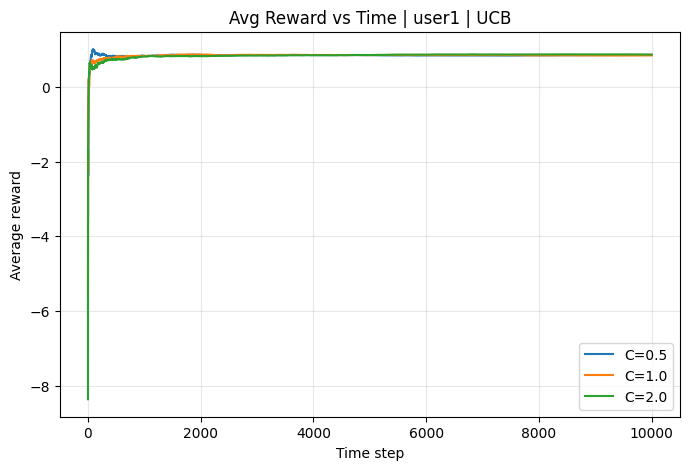

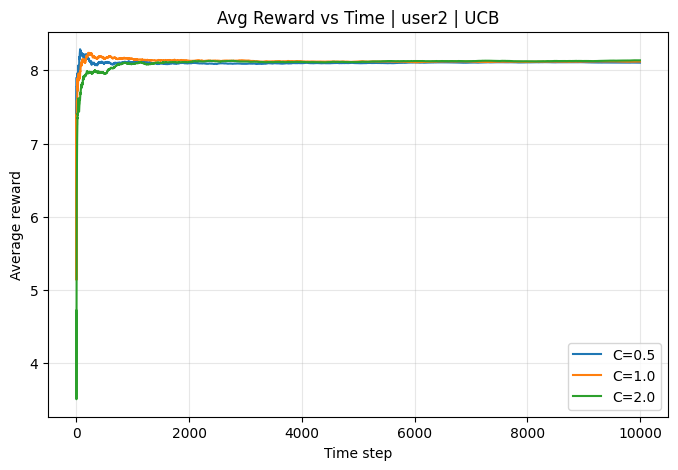

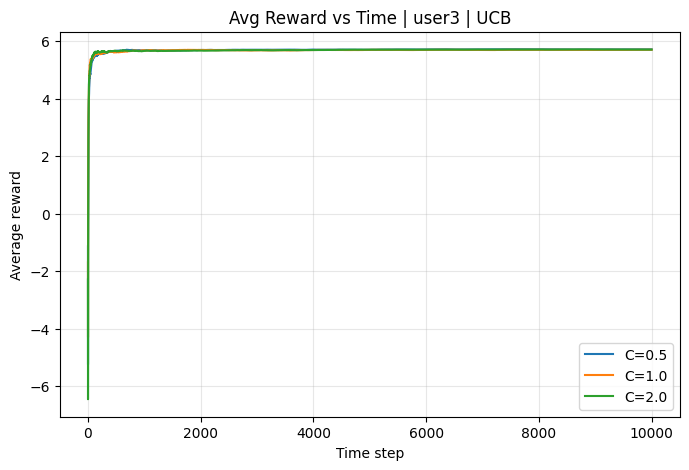

In [15]:
for context_name in contexts:
    plt.figure(figsize=(8,5))
    for C in Cs:
        avg = results_ucb[C][context_name]['avg_rewards']
        plt.plot(avg, label = f"C={C}")
    plt.title(f"Avg Reward vs Time | {context_name} | UCB")
    plt.xlabel("Time step")
    plt.ylabel("Average reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [16]:
tau = 1.0
results_softmax = {}

In [17]:
for context_idx, context_name in enumerate(contexts):
    Q = np.zeros(len(categories), dtype = float)
    N = np.zeros(len(categories), dtype = int)
    rewards = np.zeros(T, dtype = float)

    for t in range(T):
        z = Q/tau
        z = z - np.max(z)
        probs = np.exp(z)
        probs = probs / probs.sum()

        category_idx = np.random.choice(len(categories), p = probs)
        j = arm_index(context_idx, category_idx)
        r = reward_sampler.sample(j)

        N[category_idx] += 1
        Q[category_idx] += (r - Q[category_idx]) / N[category_idx]
        rewards[t] = r
    avg_rewards = np.cumsum(rewards) / (np.arange(T) + 1)

    results_softmax[context_name] = {
        "Q": Q.copy(),
        "N": N.copy(),
        "rewards": rewards,
        "avg_rewards": avg_rewards
    }

In [18]:
for context_name in contexts:
    Q = results_softmax[context_name]["Q"]
    print(f"{context_name} Q-values: " + ", ".join([f"{cat}:{q:.4f}" for cat,q in zip(categories, Q)]))
    

user1 Q-values: ENTERTAINMENT:-7.0696, EDUCATION:0.8564, TECH:-0.6313, CRIME:-4.2499
user2 Q-values: ENTERTAINMENT:6.1070, EDUCATION:3.7666, TECH:2.5811, CRIME:8.1324
user3 Q-values: ENTERTAINMENT:-2.7069, EDUCATION:-8.8579, TECH:5.7099, CRIME:-0.0698


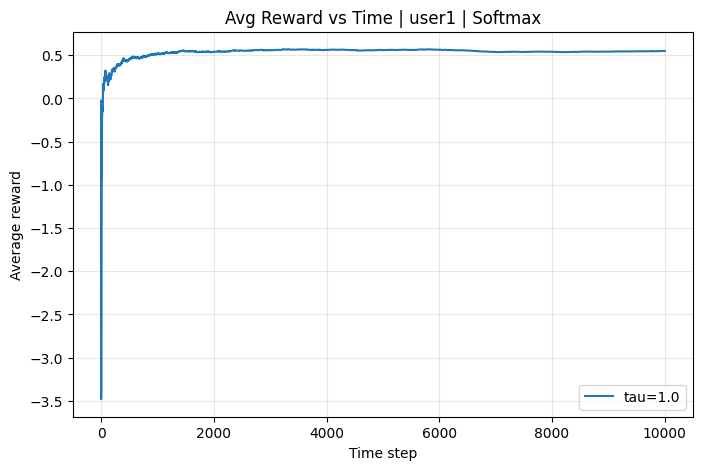

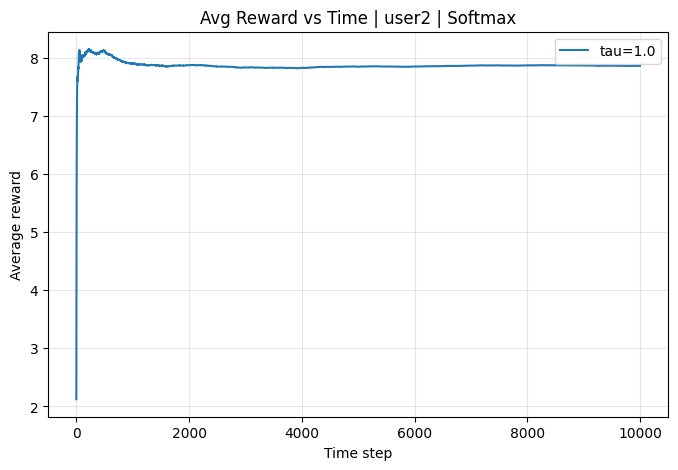

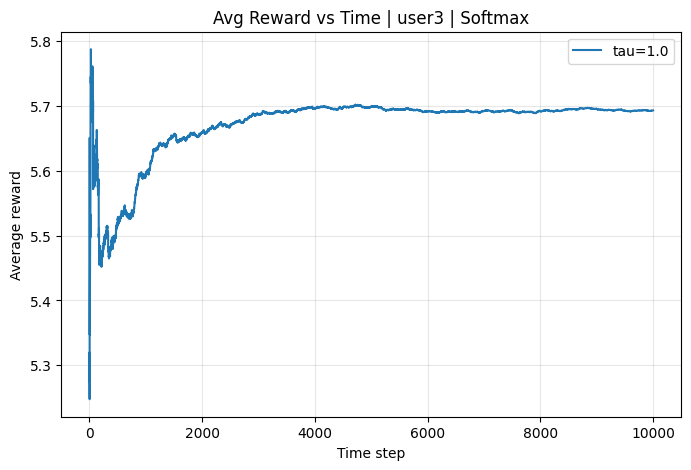

In [19]:
for context_name in contexts:
    plt.figure(figsize=(8, 5))
    avg = results_softmax[context_name]["avg_rewards"]
    plt.plot(avg, label=f"tau={tau}")
    plt.title(f"Avg Reward vs Time | {context_name} | Softmax")
    plt.xlabel("Time step")
    plt.ylabel("Average reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [20]:
def select_best_category(Q):
    # greedy (choose argmax Q)
    return int(np.argmax(Q))
    
def recommend_for_policy(users, policy_name, policy_state, articles):
    outputs = []
    user_context = users['label']
    for i, context in enumerate(user_context):
        context = str(context)
        Q = policy_state[context]["Q"]

        # choose category (greedy)
        category_idx = select_best_category(Q)
        cat = categories[category_idx]

        temp = articles.loc[articles['category']==cat]
        if len(temp) == 0:
            article = None
        else:
            random_row = temp.sample()
            
            
        outputs.append({
            "user_id": users.iloc[i]["user_id"],
            "predicted_context": context,
            "recommended_category": cat,
            "link": random_row['link'].values[0],
            "short_description": random_row['short_description'].values[0],
            "headline": random_row['headline'].values[0],
        })
    return outputs        

In [21]:
articles = pd.read_csv('news_articles.csv')
category_col = "category"
articles = articles[articles[category_col].isin(categories)].copy()
articles = articles.reset_index(drop=True)
articles.shape


(24042, 6)

In [22]:
df_test = pd.read_csv('test_pred.csv')
user_context = df_test[['user_id', 'label']]

In [23]:
# Choose the hyperparams to use for epsilon/UCB
best_eps = 0.05
best_C = 1.0

In [24]:
eps_policy = {context: results_egreedy[best_eps][context] for context in contexts}
ucb_policy = {context: results_ucb[best_C][context] for context in contexts}
softmax_policy = results_softmax


In [25]:
eps_recos = recommend_for_policy(user_context, "epsilon", eps_policy, articles)
ucb_recos = recommend_for_policy(user_context, "ucb", ucb_policy, articles)
softmax_recos = recommend_for_policy(user_context, "softmax", softmax_policy, articles)


In [27]:
eps_recos[:3]

[{'user_id': 'U4058',
  'predicted_context': 'user2',
  'recommended_category': 'CRIME',
  'link': 'https://www.huffingtonpost.com/entry/christian-pastor-rape-allegations_us_56503784e4b0258edb31b9f3',
  'short_description': 'Alfredo Huerta Zavala allegedly invoked the "name of God" and told the girls he\'d been "chosen by Christ."',
  'headline': 'Christian Pastor Accused Of Repeatedly Raping Underage Sisters'},
 {'user_id': 'U1118',
  'predicted_context': 'user1',
  'recommended_category': 'EDUCATION',
  'link': 'https://www.huffingtonpost.com/entry/a-tree-without-roots-astr_b_6001088.html',
  'short_description': 'There is no question of the cancerous effects of groups like PennCAN and the Commonwealth Foundation. It may be years before we know the full range of the damage they have inflicted on our children and schools or how long it will take to repair that damage. One thing, however, is clear: Philadelphia teachers and students deserve our interest and support.',
  'headline': 'A 